This notebook calculates the b tag scale factors for a simplified event selection (all medium instead of ttmm) based on the procedure outlined in 1a of https://twiki.cern.ch/twiki/bin/viewauth/CMS/BTagSFMethods

In [1]:
tree = SixB('/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_mmmm/Official_NMSSM/NMSSM_XToYHTo6B_MX-700_MY-300_TuneCP5_13TeV-madgraph-pythia8/ntuple.root', gnn_model=False)
tree.spherical_region()
tree.nevents

/eos/uscms/store/user/srosenzw/weaver/models/exp_sixb_official/feynnet_ranker_6b/20230731_7d266883bbfb88fe4e226783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/predict_output/2018


[18:00:23] Loading                                                                                    ]8;id=695623;file:///uscms_data/d3/srosenzw/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/utils/analysis/signal.py\signal.py]8;;\:]8;id=241501;file:///uscms_data/d3/srosenzw/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/utils/analysis/signal.py#129\129]8;;\
           Summer2018UL/maxbtag_mmmm/Official_NMSSM/NMSSM_XToYHTo6B_MX-700_MY-300_TuneCP5_13TeV-madgr              
           aph-pythia8/ntuple.root...                                                                              

REGION: concentric


63829

Efficiencies are stored in TEfficiency objects so must be handled using PyROOT

Okay, here's where the magic happens

In [2]:
from utils.tefficiency import TEfficiency

In [3]:
f_btag_eff_2018 = '/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/MultiHiggs/analysis/MultiHAnalysis/data/btag/efficiency/sixb/eff_wp_deepJet_2018.root'

In [4]:
# b_btag_eff_2018 = TEfficiency.from_root(f_btag_eff_2018, 'eff/medium_hf5_jet_pt_eta')
# c_btag_eff_2018 = TEfficiency.from_root(f_btag_eff_2018, 'eff/medium_hf4_jet_pt_eta')
# guds_btag_eff_2018 = TEfficiency.from_root(f_btag_eff_2018, 'eff/medium_hf0_jet_pt_eta')

b_btag_eff_2018 = TEfficiency.from_root(f_btag_eff_2018, 'eff/medium_hf5_jet_eta')
c_btag_eff_2018 = TEfficiency.from_root(f_btag_eff_2018, 'eff/medium_hf4_jet_eta')
guds_btag_eff_2018 = TEfficiency.from_root(f_btag_eff_2018, 'eff/medium_hf0_jet_eta')

In [5]:
jet_btag = tree.jet_btag
jet_pt = tree.jet_pt
jet_eta = tree.jet_eta
jet_hadronFlav = tree.jet_hadronFlav

In [6]:
sf_file = '/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/MultiHiggs/analysis/MultiHAnalysis/data/btag/2018/wp_deepJet_BTVPOG.csv'

In [7]:
from pandas import read_csv

In [8]:
sf_data = read_csv(sf_file)

In [9]:
medium_mask = sf_data['OperatingPoint'] == 'M'
central_mask = sf_data['sysType'] == 'central'
comb_mask = sf_data['measurementType'] == 'comb'
incl_mask = sf_data['measurementType'] == 'incl'
bFlav_mask = sf_data['jetFlavor'] == 5
cFlav_mask = sf_data['jetFlavor'] == 4
gudsFlav_mask = sf_data['jetFlavor'] == 0

b_mask = medium_mask & central_mask & comb_mask & bFlav_mask
c_mask = medium_mask & central_mask & comb_mask & cFlav_mask
guds_mask = medium_mask & central_mask & incl_mask & gudsFlav_mask

In [10]:
b_eqn = sf_data[b_mask]['formula'].iloc[0]
c_eqn = sf_data[c_mask]['formula'].iloc[0]
guds_eqn = sf_data[guds_mask]['formula'].iloc[0]

In [11]:
# def calc_eff_err(eff, pt, eta):
#     eff_nom = eff.GetEfficiency(pt, eta)
#     err_up = eff.GetAbsoluteErrorUp(pt, eta)
#     err_down = eff.GetAbsoluteErrorDown(pt, eta)
#     return eff_nom, err_up, err_down

def calc_eff_err(eff, eta):
    eff_nom = eff.GetEfficiency(eta)
    err_up = eff.GetAbsoluteErrorUp(eta)
    err_down = eff.GetAbsoluteErrorDown(eta)
    return eff_nom, err_up, err_down

def calculate_prob(pt, eta, flav, btag):
    is_guds = abs(flav) == 0
    is_c = abs(flav) == 4
    is_b = abs(flav) == 5

    assert ak.all(is_guds | is_c | is_b)

    jet_tagged = btag > 0.2783

    scope = dict(log=np.log, x=pt)
    b_sf = eval(b_eqn, scope)
    c_sf = eval(c_eqn, scope)
    guds_sf = eval(guds_eqn, scope)

    # guds_eff, guds_err_up, guds_err_down = calc_eff_err(guds_btag_eff_2018, pt, eta)
    # b_eff, b_err_up, b_err_down = calc_eff_err(b_btag_eff_2018, pt, eta)
    # c_eff, c_err_up, c_err_down = calc_eff_err(c_btag_eff_2018, pt, eta)

    guds_eff, guds_err_up, guds_err_down = calc_eff_err(guds_btag_eff_2018, eta)
    b_eff, b_err_up, b_err_down = calc_eff_err(b_btag_eff_2018, eta)
    c_eff, c_err_up, c_err_down = calc_eff_err(c_btag_eff_2018, eta)
    
    jet_eff = ak.where(is_guds, guds_eff, ak.where(is_c, c_eff, b_eff))
    jet_err_up = ak.where(is_guds, guds_err_up, ak.where(is_c, c_err_up, b_err_up))
    jet_err_down = ak.where(is_guds, guds_err_down, ak.where(is_c, c_err_down, b_err_down))

    jet_prob = ak.where(jet_tagged, jet_eff, 1 - jet_eff)
    jet_prob_up = ak.where(jet_tagged, jet_err_up, 1 - jet_err_up)
    jet_prob_down = ak.where(jet_tagged, jet_err_down, 1 - jet_err_down)

    p_mc = ak.prod(jet_prob, axis=1)
    p_mc_up = ak.prod(jet_prob_up, axis=1)
    p_mc_down = ak.prod(jet_prob_down, axis=1)

    jet_sf = ak.where(is_guds, guds_sf,ak.where(is_c, c_sf, b_sf))

    jet_prob = ak.where(jet_tagged, jet_eff*jet_sf, 1 - jet_eff*jet_sf)
    jet_prob_up = ak.where(jet_tagged, jet_err_up*jet_sf, 1 - jet_err_up*jet_sf)
    jet_prob_down = ak.where(jet_tagged, jet_err_down*jet_sf, 1 - jet_err_down*jet_sf)
    
    p_data = ak.prod(jet_prob, axis=1)
    p_data_up = ak.prod(jet_prob_up, axis=1)
    p_data_down = ak.prod(jet_prob_down, axis=1)

    return p_mc, p_mc_up, p_mc_down, p_data, p_data_up, p_data_down

In [12]:
p_mc, p_mc_up, p_mc_down, p_data, p_data_up, p_data_down = calculate_prob(jet_pt, jet_eta, jet_hadronFlav, jet_btag)

In [13]:
w = np.where(p_mc == 0, 0, p_data / p_mc )
w_up = np.where(p_mc_up == 0, 0, p_data_up / p_mc_up )
w_down = np.where(p_mc_down == 0, 0, p_data_down / p_mc_down)

In [14]:
ind = np.argmax(w)

w[ind], p_data[ind], p_mc[ind]

(5.982408727374115, 0.00010131685681586342, 1.693579650488623e-05)

In [15]:
np.mean(w)

1.0121079198579712

REGION: concentric


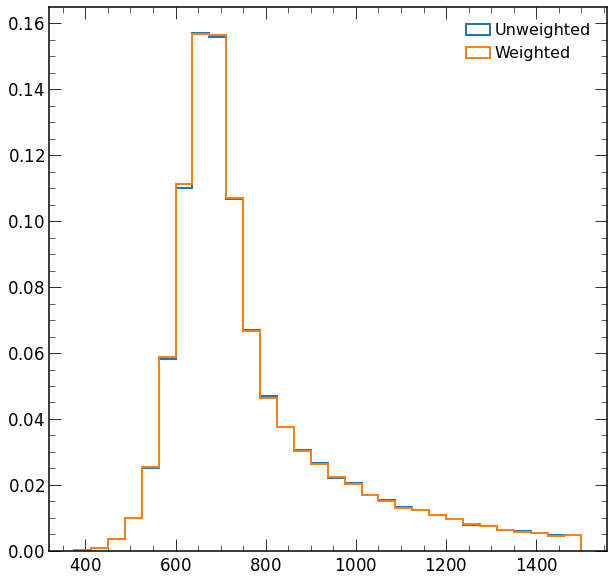

In [60]:
fig, ax = plt.subplots()

n = Hist(tree.X.m, bins=tree.mBins, ax=ax, density=True, label='Unweighted')
n = Hist(tree.X.m, bins=tree.mBins, ax=ax, weights=w, density=True, label='Weighted')
# n = Hist(tree.X.m, bins=tree.mBins, ax=ax, weights=w_up, density=True, label='Error Up')
# n = Hist(tree.X.m, bins=tree.mBins, ax=ax, weights=w_down, density=True, label='Error Down')

ax.legend()

In [56]:
bkg = Bkg(get_qcd_ttbar('maxbtag_mmmm'), gnn=False)
data = Data(get_data(jets='maxbtag_mmmm'), gnn_model=False)

Summer2018UL/maxbtag_mmmm/QCD/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_bEnriched_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_bEnriched_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_HT100to200_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL/maxbtag_mmmm/QCD/QCD_HT200to300_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
Summer2018UL

[18:27:32] Loading Summer2018UL/maxbtag_mmmm/JetHT_Data_UL/ntuple.root...                             ]8;id=383174;file:///uscms_data/d3/srosenzw/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/utils/analysis/signal.py\signal.py]8;;\:]8;id=625138;file:///uscms_data/d3/srosenzw/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/utils/analysis/signal.py#129\129]8;;\

In [58]:
bkg.spherical_region()
data.spherical_region()

REGION: concentric
REGION: concentric


In [19]:
bkg_pt = ak.concatenate(bkg.jet_pt)
bkg_eta = ak.concatenate(bkg.jet_eta)
bkg_flav = ak.concatenate(bkg.jet_hadronFlav)
bkg_btag = ak.concatenate(bkg.jet_btag)

bkg_X_m = ak.concatenate(bkg.X_m)

In [20]:
bkg_p_mc, bkg_p_mc_up, bkg_p_mc_down, bkg_p_data, bkg_p_data_up, bkg_p_data_down = calculate_prob(bkg_pt, bkg_eta, bkg_flav, bkg_btag)

In [21]:
bkg_p_data / bkg_p_mc

<Array [1.65, 0.811, 0.824, ... 0.83, 0.834] type='11178 * float64'>

In [22]:
bkg_w = np.where(bkg_p_mc == 0, 0, bkg_p_data / bkg_p_mc )
bkg_w_up = np.where(bkg_p_mc_up == 0, 0, bkg_p_data_up / bkg_p_mc_up )
bkg_w_down = np.where(bkg_p_mc_down == 0, 0, bkg_p_data_down / bkg_p_mc_down)

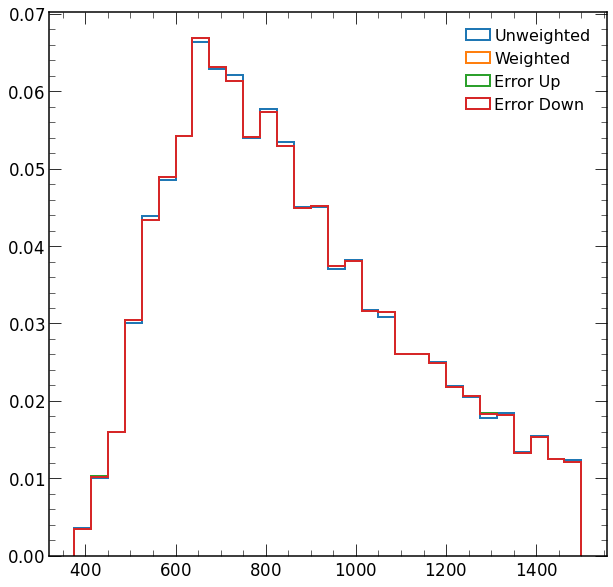

In [23]:
fig, ax = plt.subplots()

n = Hist(bkg_X_m, bins=tree.mBins, ax=ax, density=True, label='Unweighted')
# ax.hist(bkg_X_m.to_numpy(), bins=tree.mBins, weights=w)
n = Hist(bkg_X_m, bins=tree.mBins, ax=ax, weights=bkg_w, density=True, label='Weighted')
n = Hist(bkg_X_m, bins=tree.mBins, ax=ax, weights=bkg_w_up, density=True, label='Error Up')
n = Hist(bkg_X_m, bins=tree.mBins, ax=ax, weights=bkg_w_down, density=True, label='Error Down')

ax.legend()

Unweighted but scaled by cross section

In [47]:
bkg.sample

['QCD_bEnriched_HT300to500',
 'QCD_bEnriched_HT500to700',
 'QCD_bEnriched_HT700to1000',
 'QCD_bEnriched_HT1000to1500',
 'QCD_bEnriched_HT1500to2000',
 'QCD_bEnriched_HT2000toInf',
 'QCD_HT300to500_BGenFilter',
 'QCD_HT500to700_BGenFilter',
 'QCD_HT700to1000_BGenFilter',
 'QCD_HT1000to1500_BGenFilter',
 'QCD_HT1500to2000_BGenFilter',
 'QCD_HT2000toInf_BGenFilter',
 'TTJets']

In [59]:
bkg.scale[bkg.ls_mask]

array([9.01530909e+02, 9.01530909e+02, 9.01530909e+02, ...,
       7.39101051e-04, 7.39101051e-04, 7.39101051e-04])

In [48]:
np.unique(bkg.scale[bkg.ls_mask])

array([7.39101051e-04, 8.29351343e-02, 5.28191062e-01, 3.40194955e+00,
       3.67413040e+00, 2.20395333e+01, 4.47490637e+01, 7.23168244e+01,
       3.09467397e+02, 3.96087259e+02, 9.01530909e+02, 1.70657491e+03,
       7.35300972e+03])

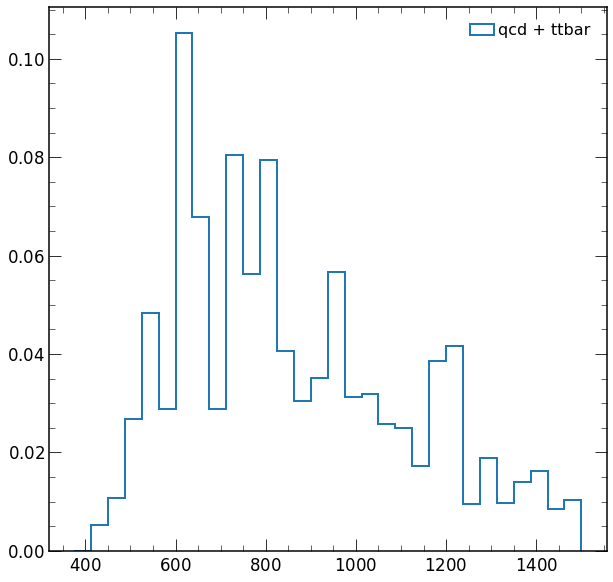

In [49]:
fig, ax = plt.subplots()

# n = Hist(tree.X.m[tree.ls_mask], bins=tree.mBins, ax=ax, density=True, label='signal = (700, 300)', weights=tree.scale)
n = Hist(bkg_X_m, bins=tree.mBins, ax=ax, density=True, weights=bkg.scale, label='qcd + ttbar')
# n = Hist(data.X.m[data.ls_mask], bins=tree.mBins, ax=ax, density=True, color='k', label='data')

ax.legend()

Weighted but unscaled by cross section

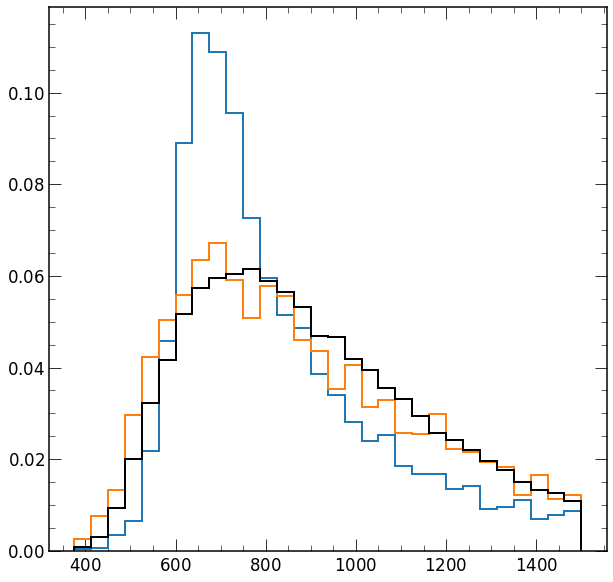

In [33]:
fig, ax = plt.subplots()

n = Hist(tree.X.m[tree.ls_mask], bins=tree.mBins, ax=ax, density=True, weights=w[tree.ls_mask], label='signal = (700, 300)')
n = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, density=True, weights=bkg_w[bkg.ls_mask])
n = Hist(data.X.m[data.ls_mask], bins=tree.mBins, ax=ax, density=True, color='k')

Weighted and scaled by cross section

Text(1.0, 1.0, 'Validation Signal Region')

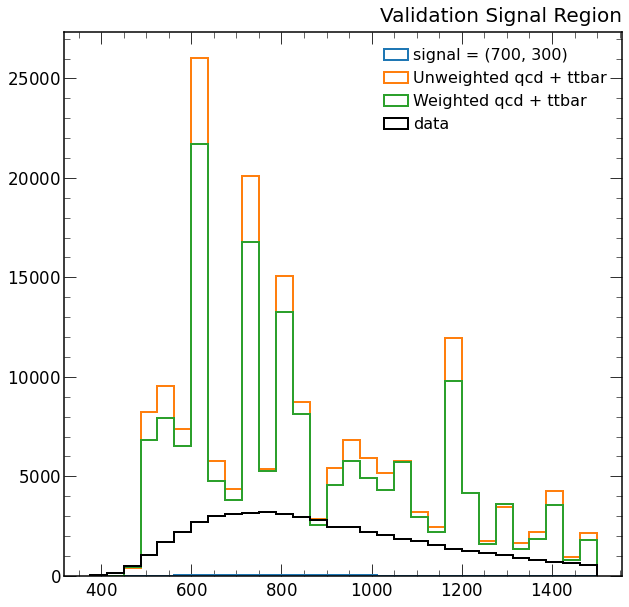

In [34]:
fig, ax = plt.subplots()

n = Hist(tree.X.m[tree.ls_mask], bins=tree.mBins, ax=ax, weights=w[tree.ls_mask]*tree.scale, label='signal = (700, 300)')
n = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, weights=bkg.scale[bkg.ls_mask], label='Unweighted qcd + ttbar')
n = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, weights=bkg_w[bkg.ls_mask]*bkg.scale[bkg.ls_mask], label='Weighted qcd + ttbar')
n = Hist(data.X.m[data.ls_mask], bins=tree.mBins, ax=ax, label='data', color='k')

ax.set_title('Validation Signal Region')

Text(1.0, 1.0, 'Validation Signal Region')

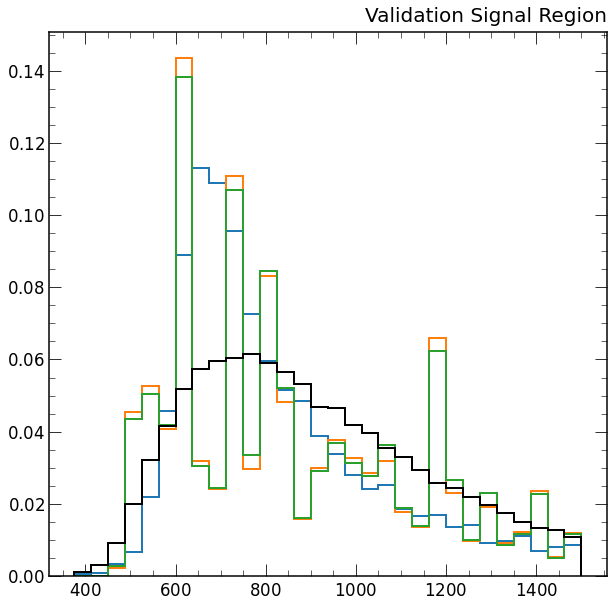

In [35]:
fig, ax = plt.subplots()

n = Hist(tree.X.m[tree.ls_mask], bins=tree.mBins, ax=ax, density=True, weights=w[tree.ls_mask]*tree.scale, label='signal = (700, 300)')
n = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, density=True, weights=bkg.scale[bkg.ls_mask], label='Unweighted qcd + ttbar')
n = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, density=True, weights=bkg_w[bkg.ls_mask]*bkg.scale[bkg.ls_mask], label='Weighted qcd + ttbar')
n = Hist(data.X.m[data.ls_mask], bins=tree.mBins, ax=ax, density=True, label='data', color='k')

ax.set_title('Validation Signal Region')

In [36]:
from utils.plotter import Ratio

In [37]:
def get_ratio(n1, n2):
    n_ratio = n1 / n2
    n_ratio = np.where(np.isnan(n_ratio), 0, n_ratio)
    n_ratio = np.where(np.isposinf(n_ratio), 0, n_ratio)
    return n_ratio

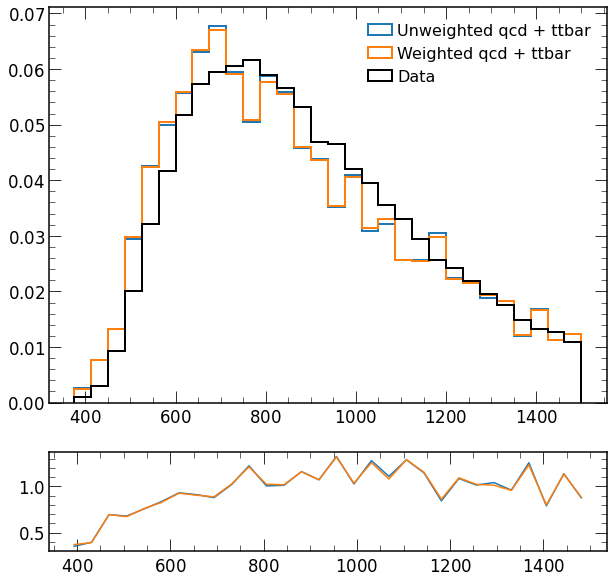

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios':[4,1]})

x = (tree.mBins[1:] + tree.mBins[:-1]) / 2

ax = axs[0]
n_bkg1 = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, density=True, label='Unweighted qcd + ttbar')
n_bkg2 = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, density=True, weights=bkg_w[bkg.ls_mask], label='Weighted qcd + ttbar')
n_data = Hist(data.X.m[data.ls_mask], bins=tree.mBins, ax=ax, density=True, label='Data', color='k')

n_ratio1 = get_ratio(n_data, n_bkg1)
n_ratio2 = get_ratio(n_data, n_bkg2)

ax.legend()

ax = axs[1]
ax.plot(x, n_ratio1)
ax.plot(x, n_ratio2)

Text(1.0, 1.0, 'Validation Signal Region')

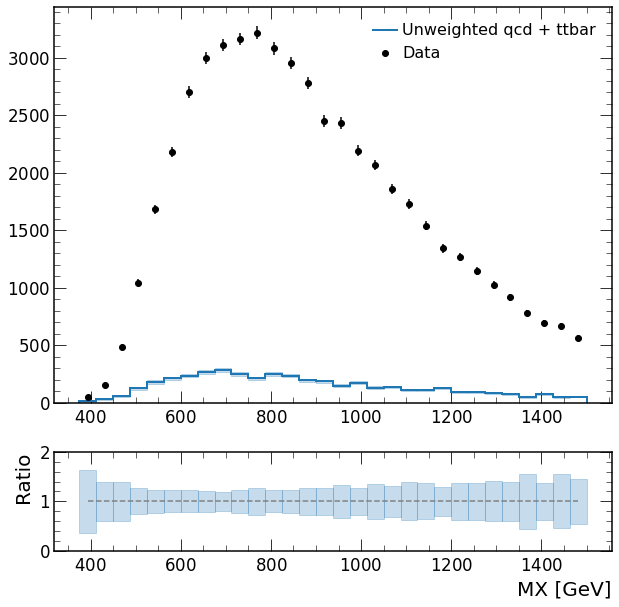

In [39]:
# n = Hist(tree.X.m[tree.ls_mask], bins=tree.mBins, ax=ax, density=True, weights=w[tree.ls_mask])
n_num, n_denom, n_ratio = Ratio(
    data=[bkg_X_m[bkg.ls_mask], data.X.m[data.ls_mask]],
    bins=tree.mBins,
    labels=['Unweighted qcd + ttbar', 'Data'],
    xlabel='MX [GeV]'
    )
# n = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, density=True, label='Unweighted qcd + ttbar')
# n = Hist(bkg_X_m[bkg.ls_mask], bins=tree.mBins, ax=ax, density=True, weights=bkg_w[bkg.ls_mask], label='Weighted qcd + ttbar')
# n = Hist(data.X.m[data.ls_mask], bins=tree.mBins, ax=ax, density=True, label='Data', color='k')

ax.set_title('Validation Signal Region')

In [50]:
bkg.jet_btag

[<Array [[1, 0.997, 0.91, ... 0.0221, 0.00429]] type='45 * var * float32'>,
 <Array [[0.999, 0.997, ... 0.141, 0.0536]] type='326 * var * float32'>,
 <Array [[0.994, 0.986, ... 0.285, 0.0274]] type='196 * var * float32'>,
 <Array [[1, 0.99, 0.838, ... 0.0855, 0.0779]] type='609 * var * float32'>,
 <Array [[0.998, 0.997, ... 0.337, 0.00677]] type='455 * var * float32'>,
 <Array [[0.999, 0.954, ... 0.113, 0.0162]] type='487 * var * float32'>,
 <Array [[0.996, 0.99, ... 0.00497, 0.00409]] type='12 * var * float32'>,
 <Array [[0.989, 0.982, ... 0.0464, 0.0126]] type='65 * var * float32'>,
 <Array [[1, 0.989, 0.972, ... 0.0221, 0.00494]] type='153 * var * float32'>,
 <Array [[1, 0.999, 0.972, ... 0.0192, 0.0122]] type='53 * var * float32'>,
 <Array [[1, 0.997, 0.992, ... 0.0494, 0.0481]] type='125 * var * float32'>,
 <Array [[1, 1, 0.999, ... 0.112, 0.0942]] type='167 * var * float32'>,
 <Array [[0.998, 0.997, ... 0.14, 0.0826]] type='8485 * var * float32'>]

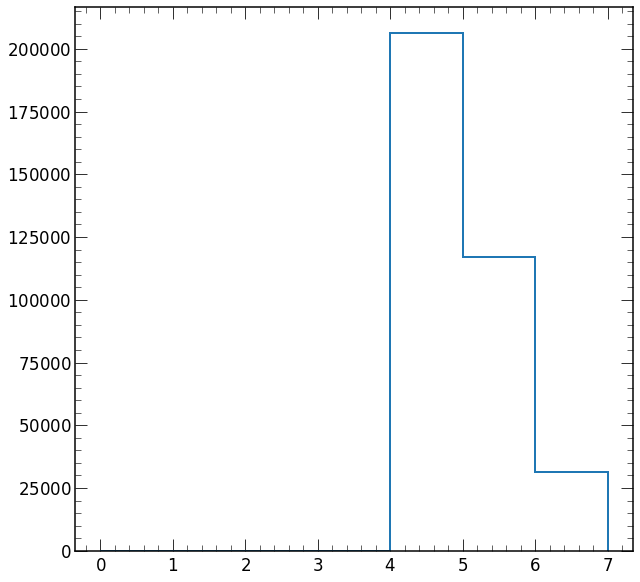

In [53]:
fig, ax = plt.subplots()

bkg_loose = ak.sum(ak.concatenate(bkg.jet_btag) > 0.0490, axis=1)
n = Hist(bkg_loose, weights=bkg.scale, bins=np.arange(8), ax=ax)